# Overview
This notebook will experiment with using extracted features from CNN as a training set for classical
machine learning algorithms. So instead of using SVM to to train on a raw RGB image (224X224X3=150528) it will train on feature vector size of 100. 

The extracted feature sets for the images are stored in pickle files which are loaded.

## Inital Set Up

In [4]:
import sys
import os
sys.path.insert(0, '../')
os.chdir('..')

In [5]:
import numpy as np
import itertools
from pprint import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style()
sns.set(font_scale=1.2)  # crazy big
# If the user has qgrid installed, then lets use it
try:
    from qgrid import show_grid
except:
    print('Using default Jupyter Dataframe...')
    def show_grid(df):
        return df
    
from notebookutils import create_tasks, JobRunner, load_data

%matplotlib inline

Using default Jupyter Dataframe...


## Loading Training and Testing Data Sets

In [6]:
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_class_weight
from collections import OrderedDict

train_data_lidar = "trained/encoded/train_resnet50_lidar.pkl"
valid_data_lidar = "trained/encoded/val_resnet50_lidar.pkl"
test_data_lidar = "trained/encoded/test_resnet50_lidar.pkl"
# all_data_lidar = "trained/all_resnet50_lidar.pkl"

train_data_rgb = "trained/encoded/train_resnet50_rgb.pkl"
valid_data_rgb = "trained/encoded/val_resnet50_rgb.pkl"
test_data_rgb = "trained/encoded/test_resnet50_rgb.pkl"
# all_data_rgb = "trained/all_resnet50_rgb.pkl"

# x = feautres, y = labels, f = file_names, l = lidar, r=rgb, t = train, v = validation, test = test
shuffle_init = False
xl_t, fl_t, yl_t = load_data(train_data_lidar, shuffle=shuffle_init)
xl_v, fl_v, yl_v = load_data(valid_data_lidar, shuffle=shuffle_init)
xl_test, fl_test, yl_test = load_data(test_data_lidar, shuffle=shuffle_init)
xl_all, yl_all = (None, None)
# xl_all, fl_all, yl_all = load_data(all_data_lidar, shuffle=shuffle_init)

xr_t, fr_t, yr_t = load_data(train_data_rgb, shuffle=shuffle_init)
xr_v, fr_v, yr_v = load_data(valid_data_rgb, shuffle=shuffle_init)
xr_test, fr_test, yr_test = load_data(test_data_rgb, shuffle=shuffle_init)
xr_all, yr_all = (None, None)
# xr_all, fr_all, yr_all = load_data(all_data_rgb, shuffle=shuffle_init)

# Concatenate RGB and LIDAR features
xd_t = np.concatenate((xl_t, xr_t), axis=1)
xd_v = np.concatenate((xl_v, xr_v), axis=1)
xd_test = np.concatenate((xl_test, xr_test), axis=1)
# xd_all = np.concatenate((xl_all, xr_all), axis=1)
xd_all = None

In [7]:
print(xr_t.shape)
print(xl_t.shape)
print(xd_t.shape)

(5212, 2048)
(5212, 2048)
(5212, 4096)


## Define Algorithms and Parameters

In [8]:
models = {
    "SVC": {
        "C": [
          1.0,
          10.0,
          100.0
        ],
        "kernel": [
          "linear",
          "rbf",
          "poly",
          "sigmoid"
        ]
    },
    "RandomForestClassifier": 
    {
        "criterion": [
          "gini",
          "entropy"
        ],
        "max_depth": [
          5,
          10,
          50
        ],

        "n_estimators": [
          5,
          10,
          50
        ]
    }
}




    
tasks = create_tasks(models)
# pp(tasks)

## LIDAR

In [ ]:
job_runner = JobRunner(xl_t, yl_t, xl_v, yl_v, xl_test, yl_test, tasks, inputs='lidar', x_all=xl_all, y_all=yl_all)
lidar_results = job_runner.run_tasks()

## RGB

In [ ]:
job_runner = JobRunner(xr_t, yr_t, xr_v, yr_v, xr_test, yr_test, tasks, inputs='rgb', x_all=xr_all, y_all=yr_all)

rgb_results = job_runner.run_tasks()

## DUAL

In [8]:
job_runner = JobRunner(xd_t, yl_t, xd_v, yl_v, xd_test, yl_test, tasks, inputs='dual', x_all=xd_all, y_all=yl_all)

dual_results = job_runner.run_tasks()

In [9]:
import pandas as pd
import qgrid

# [{'name': 'resnet50dual_test', 'test_acc': 0.97222222222222221},
#  {'name': 'resnet50dual_valid', 'val_acc': 0.99513381995133821},
#  {'all_acc': 0.9282533028930724, 'name': 'resnet50dual_all'}]



nn_results = [
    {
        "input": 'rgb',
        'name': 'Resnet50',
        'params': str({'fc1': 100}),
        "all_acc": .7313,
        'test_acc': .8472,   #comes from predict.py test-.84,  all - .73
        'train_acc': .979, # comes from mutli train file
        'valid_acc': .898  # comes from mutli train file
    },
    {
        "input": 'lidar',
        'name': 'Resnet50',
        'params': str({'fc1': 100}),
        "all_acc": .8769,
        'test_acc': .9583,      # comes from predict.py test-.95,  all-.87
        'train_acc': 0.98369, # comes from mutli train file
        'valid_acc': 0.98297 # comes from mutli train file
    }
]
all_results = rgb_results + lidar_results + dual_results + nn_results
df = pd.DataFrame.from_dict(all_results)
# df.to_csv('results/classical_results_final.csv')
qgrid.show_grid(df)

Widget Javascript not detected.  It may not be installed or enabled properly.


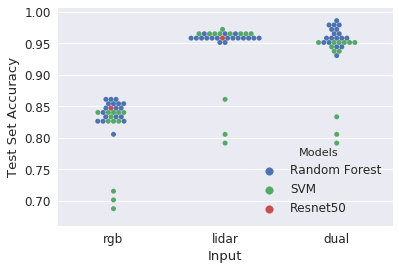

In [10]:
current_palette = sns.color_palette()
custom_pallete = {"SVM": current_palette[1], "Resnet50": current_palette[2], "Random Forest": current_palette[0]}

ax = sns.swarmplot(x="input", y="test_acc", hue="name", data=df, palette=custom_pallete);
ax.legend_.set_title("Models")
# ax._legend.set_bbox_to_anchor((.76, .35))
ax.set(xlabel='Input', ylabel='Test Set Accuracy', title='')
plt.savefig('results/test_data_set_classical.eps')

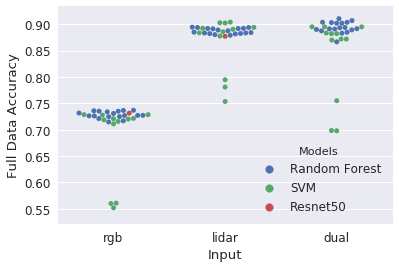

In [11]:
ax = sns.swarmplot(x="input", y="all_acc", hue="name", data=df, palette=custom_pallete);
ax.legend_.set_title("Models")
# ax._legend.set_bbox_to_anchor((.76, .35))
ax.set(xlabel='Input', ylabel='Full Data Accuracy', title='')
plt.savefig('results/all_data_set_classical.eps')

# Metric Calculations
This will calculate some metrics for us for Completeness, Correctness, and Quality

In [84]:
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, classification_report
# joblib.dump(all_results, 'results/saved_classifiers.pkl')
# all_results= joblib.load('results/saved_classifiers.pkl')
classifier_dual = all_results[65] # best dual classifier

In [111]:
import util
import importlib
import config

def calculate_metrics(cf):
    FP = cf.sum(axis=0) - np.diag(cf)  
    FN = cf.sum(axis=1) - np.diag(cf)
    TP = np.diag(cf)
    TN = cf.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    PPV = TP/(TP+FP)

    # Precision or positive predictive value
    QUAL = TP/(TP+FP+FN)
    matrix = np.column_stack((TPR.transpose(), PPV.transpose(), QUAL.transpose()))
    
    return matrix

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        25
        1.0       1.00      0.97      0.98        32
        2.0       0.92      1.00      0.96        22
        3.0       1.00      0.98      0.99        42
        4.0       1.00      1.00      1.00        10
        5.0       1.00      1.00      1.00        13

avg / total       0.99      0.99      0.99       144

Confusion matrix, without normalization
[[25  0  0  0  0  0]
 [ 0 31  1  0  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  1 41  0  0]
 [ 0  0  0  0 10  0]
 [ 0  0  0  0  0 13]]
[[ 1.          1.          1.        ]
 [ 0.96875     1.          0.96875   ]
 [ 1.          0.91666667  0.91666667]
 [ 0.97619048  1.          0.97619048]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]]


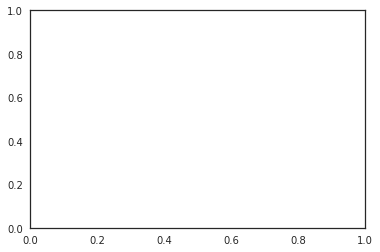

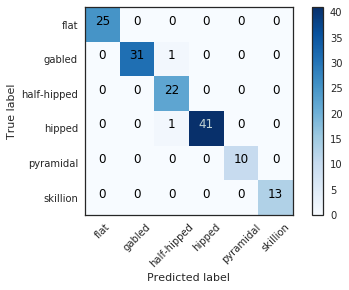

In [112]:
# Test Set
y_pred = classifier_dual['classifier'].predict(xd_test)
cf = confusion_matrix(yl_test, y_pred)
s1 = classification_report(yl_test, y_pred)
print(s1)

util.plot_confusion_matrix(cf, config.classes, accuracy=None, normalize=False,output='dual_rf_test')
print(calculate_metrics(cf))


             precision    recall  f1-score   support

        0.0       0.94      0.91      0.92      8679
        1.0       0.97      0.90      0.94     15572
        2.0       0.42      0.85      0.56       505
        3.0       0.75      0.90      0.82      1535
        4.0       0.69      0.81      0.75       112
        5.0       0.27      0.74      0.40       316

avg / total       0.93      0.90      0.91     26719

Normalized confusion matrix
[[  9.12317087e-01   3.18008987e-02   5.18492914e-03   7.60456274e-03
    1.15220648e-03   4.19403157e-02]
 [  2.83842795e-02   9.02067814e-01   2.95402004e-02   2.27973285e-02
    1.92653481e-04   1.70177241e-02]
 [  5.94059406e-03   9.50495050e-02   8.47524752e-01   3.56435644e-02
    1.98019802e-03   1.38613861e-02]
 [  1.75895765e-02   1.23778502e-02   5.60260586e-02   8.95765472e-01
    1.75895765e-02   6.51465798e-04]
 [  8.92857143e-02   8.92857143e-03   8.92857143e-03   8.03571429e-02
    8.12500000e-01   0.00000000e+00]
 [  1.7405

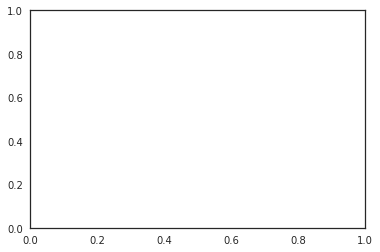

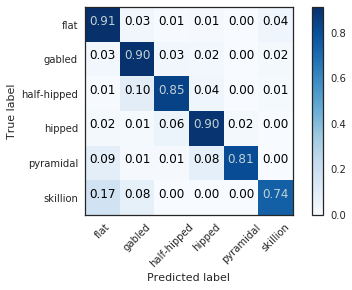

In [113]:
# Full Data Set, not using this in paper
y_pred = classifier_dual['classifier'].predict(xd_all)
cf = confusion_matrix(yl_all, y_pred)
s1 = classification_report(yl_all, y_pred)
print(s1)

util.plot_confusion_matrix(cf, config.classes, accuracy=None, normalize=True, output='dual_rf_all')
print(calculate_metrics(cf))